# Solvent-accessible surfaces vs solvent-excluded surfaces

Solvent-excluded surfaces are intuitive, but difficult to calculate.

A starting point is the hard-sphere approximation of a molecule. In this approximation, each atom is a perfect sphere with radius defined by the van Der Waals radius. 

The solvent-accessible surface (SAS) is similar to the hard-sphere surface, but removes any surfaces on the internal parts of the molecule, as well as tiny crevices on the external parts. Imagine a probe sphere rolling around the surface of a molecule. The SAS is the shape defined by the probe's path. It's reasonably easy to calculate SAS-area (SASA) using the [Shrake-Rupley](https://en.wikipedia.org/wiki/Accessible_surface_area) algorithm.

A related concept is the solvent-excluded surface (SES), which is where life gets difficult. The SES is the hard sphere approximation when there is room for a probe sphere to contact an atom surface. Inbetween two atoms, however, the SES becomes the surface of the probe sphere, which is known as a re-entrant surface. The canonical analytical approach to calculating it is by Connolly's approach ([doi](https://doi.org/10.1107/S0021889883010985)), which uses hourglass-shaped patches to fill the SES between atoms.

### Here's an outline of the three surfaces from the Chimera docs:

![bah](https://www.cgl.ucsf.edu/chimerax/docs/user/commands/surface-diagram.png)

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy.interpolate import Rbf
from SESMesh import SESMesh

# SETUP - 2D test case
Generate two 'atoms' - really just 2D point clouds sampled from the surfaces of two circles. We will also copy those points and expand their distance from the atom centres by one 'probe radius' to sample points from the SAS.

Note: for the rest of the notebook, the atom-surface points will be **BLUE**, and the SAS/SES points will be **ORANGE**.

In [2]:
def plot_points(p, ep):
    """Plots the surface points (p) and extended surface points (ep)"""
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    ax.scatter(*p.T, s=80)
    ax.scatter(*ep.T, s=80)

    ax.set_aspect('equal')
    return fig, ax 

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

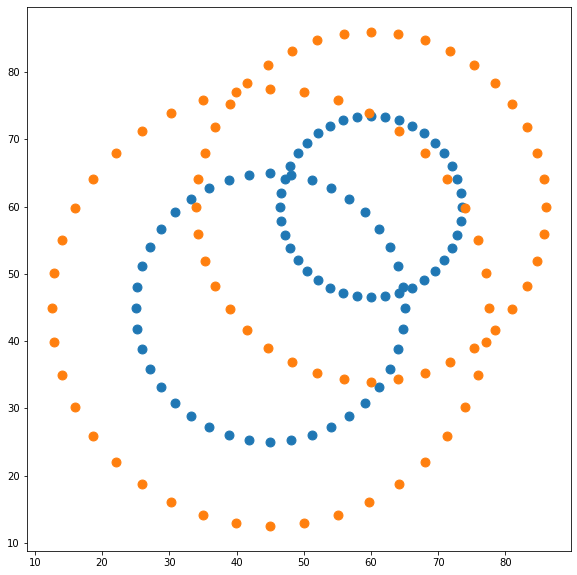

In [3]:
#make two 2d atoms:
positions = np.array([[45,45], [60,60]])
radii = np.array([20, 13.5])

#the radius of the probe circle.
PROBERAD = 12.5



#initialise the mesher
sesmol = SESMesh(PROBERAD)
#generate a 2d template:
sesmol.circle_points(40)
#plt.scatter(*sesmol.template_points.T)

#generate surface and extended points for two atoms (defined above)
sesmol.generate_points(positions, radii)
plot_points(sesmol.sp, sesmol.ep)

# Remove points that lie inside another atom.

These are the easy ones. Simply calculate the minimum distance between a blue point and the atom coordinates. If it's less than the radius of that atom, get rid of it.


At this stage, we have points on the SAS (orange), and points on the VDW (blue).

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

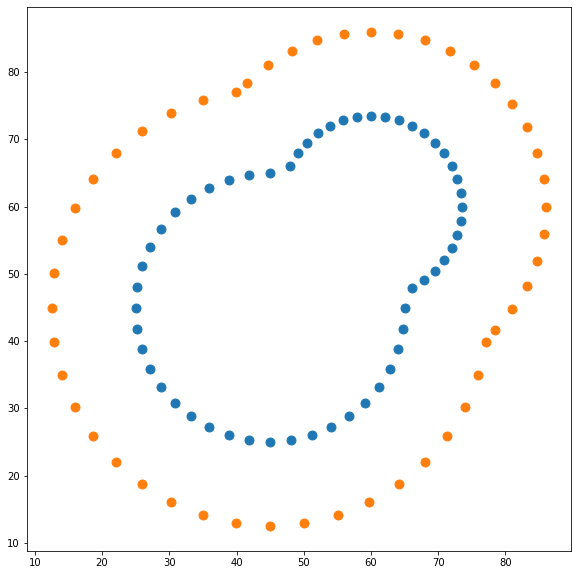

In [4]:
sesmol.remove_bad_surface_points()
sesmol.remove_bad_extended_points()
plot_points(sesmol.sp, sesmol.ep)

# Now translate the problematic blue points to be 1 probe radius from their nearest probe

All points on the SES should be exactly one probe radius away from the locus of the probe sphere. Recognising that  orange points are samples from the locus surface, we can determine if a blue point is in the wrong place when its distance to the nearest orange point is greater than the probe radius. 

To fix that, we simply translate each blue point towards it's nearest orange point such that it lies one probe radius away:

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

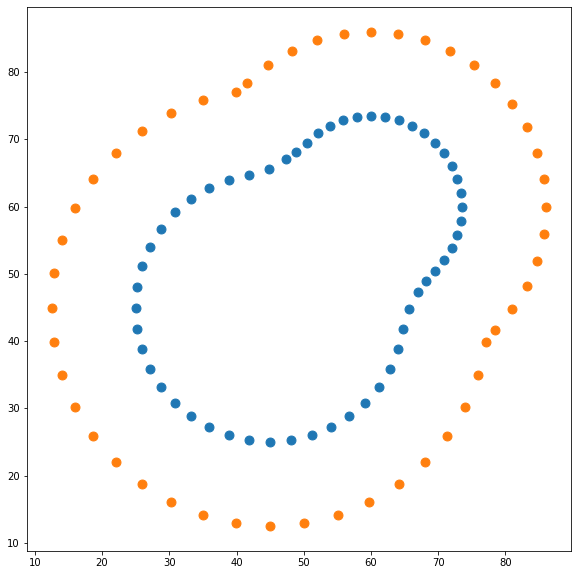

In [5]:
sesmol.translate_reentrant_surfaces()
plot_points(sesmol.sp, sesmol.ep)

# Interpolate these points onto a grid.
Thanks to the translation step for the re-entrant surfaces, we now know that each blue point will have zero distance to the SES. Likewise, we know each orange probe point sits exactly one probe-radius distance from the SES. We can add one more bit of detail - the atomic centres are one negative atom radius from the SES. 

This is enough information to interpolate a signed-distance field, which will then be used to create a mesh. 


In this case I am using scipy's Rbf interpolation. This scales quadratically (meaning please dont try to mesh a protein-sized molecule) but it gets nice smooth results.

In [6]:
sesmol.sample_sdf()
sesmol.gen_grid(gridsize=2)
sesmol.interp()

0
1


# Sanity check: visualize the SDF
An SDF is a signed distance field, i.e. a grid where the values of each gridpoint are the distance to the 'surface', in this case the SES. 



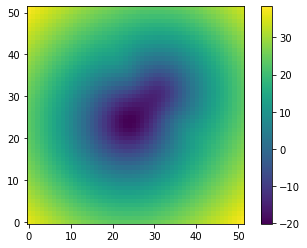

In [7]:
plt.imshow(sesmol.sdf, origin='lower')
plt.colorbar()

# Find contours with marching squares
This algorithm calculates a boundary surface by interpolating between grid points to guess the position of the zero point. 

Thanks to the smooth Rbf interpolation of the grid points, the surface perfectly recapitulates the SES!

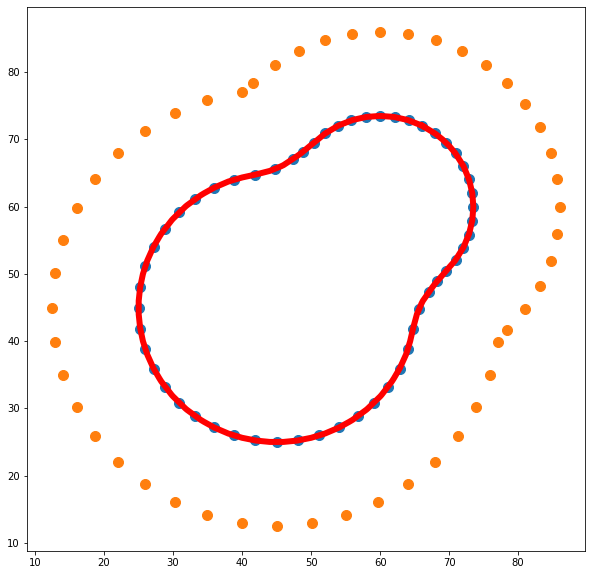

In [8]:
fig,ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
contours = find_contours(sesmol.sdf, 0)
for n, contour in enumerate(contours):
    ax.plot( contour[:, 1]*sesmol.gridsize+sesmol.min_coords[0], 
            contour[:, 0]*sesmol.gridsize+sesmol.min_coords[1], linewidth=6, c='red')



ax.scatter(*sesmol.sp.T,s=100,c='C0')
ax.scatter(*sesmol.ep.T,s=100,c='C1')

# Now do a molecule

All the operations are basically the same thanks to numpy broadcasting. The only difference is we sample points from a sphere (rather than a circle) using a [cool algorithm](https://stackoverflow.com/a/44164075/3089865) and then apply `'marching cubes'` rather than `'marching squares'`.

Run in a local notebook in order to see the mesh using [meshplot](https://skoch9.github.io/meshplot/tutorial/)

0
1
2


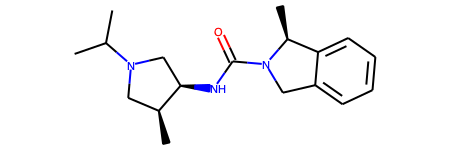

In [9]:
from mol3d import Mol3D
from rdkit import Chem

mol = Mol3D('CC(C)N1C[C@H](C)[C@H](NC(=O)N2Cc3ccccc3[C@@H]2C)C1')
mol.embed3d(1, hydrogens=True)

positions = mol.get_pos(0)
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.mol.GetAtoms()])#+0.1

#init object
sesmol = SESMesh(1.4)
#generate a 2d template:
sesmol.golden_spiral(60)
#plt.scatter(*sesmol.template_points.T)

#generate surface and extended points for two atoms (defined above)
sesmol.generate_points(positions, radii)


sesmol.remove_bad_surface_points()
sesmol.remove_bad_extended_points()
sesmol.translate_reentrant_surfaces()
sesmol.sample_sdf()
sesmol.gen_grid(gridsize=0.5)
sesmol.interp()

mol.twoD

In [11]:
from skimage.measure import marching_cubes_lewiner
vert, faces, norm, values= marching_cubes_lewiner(sesmol.sdf, 
                                                  0, 
                                                  spacing=(sesmol.gridsize, 
                                                           sesmol.gridsize,
                                                          sesmol.gridsize))

import meshplot as mp
p = mp.plot(vert*sesmol.gridsize+sesmol.min_coords, faces)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-7.818649…

In [12]:
# ##Alternatively, view with o3d:

# import open3d as o3d
# mesh = o3d.geometry.TriangleMesh()
# mesh.vertices = o3d.utility.Vector3dVector(vert*sesmol.gridsize+sesmol.min_coords)
# mesh.triangles = o3d.utility.Vector3iVector(faces)
# mesh.compute_triangle_normals()
# mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh])